In [1]:
import pandas as pd
# from modin.config import Engine
# Engine.put("ray")
# import modin.pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.ticker as mticker
import matplotlib
import matplotlib.dates as mdates
import numpy as np
import logging
import re
from joblib import Parallel, delayed
import gensim
import gensim.downloader
import gc

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import BatchSampler, RandomSampler, SequentialSampler

from torchmetrics import AUROC, Accuracy, F1Score

sns.set(font_scale=1.4)
sns.set_style('whitegrid')
logging.basicConfig(level=logging.INFO)

%matplotlib inline

In [2]:
train_data = pd.read_csv('archive/train.csv')
valid_data = pd.read_csv('archive/valid.csv')

In [3]:
def date_to_datetime(arg):
    return datetime.strptime(arg, '%Y-%m-%d %H:%M:%S')

In [4]:
train_data['CreationDate'] = train_data['CreationDate'].map(date_to_datetime)
train_data.sort_values('Y', inplace=True)
train_data

,Id,Title,Body,Tags,CreationDate,Y
22972,45310925,How to get a complete topic distribution for a...,<p>When I train my lda model as such</p>\n\n<p...,<python><gensim><lda>,2017-07-25 18:21:31,HQ
10972,39634954,nvm uninstall doesn't actually uninstall the n...,<p>So I'm trying to clear out older versions o...,<node.js><nvm>,2016-09-22 09:16:33,HQ
10974,39635861,Unable to contact local DTServiceHub to bless ...,<p>When I run my basic Xcode project in simula...,<ios><xcode8>,2016-09-22 09:54:23,HQ
10975,39637588,C# How to add a property setter in derived class?,<p>I have a requirement where I have a number ...,<c#><inheritance>,2016-09-22 11:19:19,HQ
10976,39637675,What is the difference between @types.coroutin...,<p>Documentations say:</p>\n\n<blockquote>\n ...,<python><asynchronous><python-3.5>,2016-09-22 11:23:13,HQ
...,...,...,...,...,...,...
31785,50165626,dice number showing with c# on unity 3d,I wrote a code to show the number of the dice ...,<c#><unity3d><3d>,2018-05-04 00:50:45,LQ_EDIT
31784,50163974,powershell generate word list from two csv fil...,I'm trying to use powershell to import two csv...,<powershell><csv>,2018-05-03 21:16:52,LQ_EDIT
13573,40687487,Why this regex is not working?,Test URL:\r\n\r\n www-test1.examples.com\r\...,<java><regex>,2016-11-18 23:28:06,LQ_EDIT
31792,50172042,installing packag (gahgu95av2.db) in R,I have a problem with installing pack (gahgu95...,<r>,2018-05-04 09:48:05,LQ_EDIT


In [5]:
valid_data['CreationDate'] = valid_data['CreationDate'].map(date_to_datetime)
valid_data.sort_values('Y', inplace=True)
valid_data

,Id,Title,Body,Tags,CreationDate,Y
5708,42226798,Remove duplicate data from query results,<p>I have the following query:</p>\n\n<pre><co...,<sql-server><tsql>,2017-02-14 12:56:30,HQ
5841,42394999,Why should I use Validators.compose()?,<p>I have a field I want to validate with mult...,<angular><angular2-forms><angular2-formbuilder>,2017-02-22 14:59:19,HQ
5839,42393545,"How to fix ""Missing Gradle project configurati...","<p>As an Eclipse user, I always liked the Grad...",<eclipse><gradle><configuration><buildship>,2017-02-22 13:58:32,HQ
5838,42390860,Configure active profile in SpringBoot via Maven,<p>I'm trying to set an active profile in Spri...,<java><spring><maven><spring-boot>,2017-02-22 12:01:00,HQ
5836,42389649,'openURL' was deprecated in iOS 10.0: Please u...,<p>I have working open webLink url codes in <c...,<ios><uiwebview><swift3>,2017-02-22 11:12:41,HQ
...,...,...,...,...,...,...
8218,46154987,How avoid recurrent code in block with ruby ?,I try to convert a bash script in a ruby scrip...,<ruby><linux>,2017-09-11 11:45:53,LQ_EDIT
8217,46150920,What is the best way (steps) to implement User...,Trying to use Apache Ignite as in-memory datab...,<java><ignite>,2017-09-11 08:06:24,LQ_EDIT
8214,46147329,Converting lower case hex to uppercase in python,Can anyone please help me in converting a hex ...,<python><string><mac-address>,2017-09-11 02:13:22,LQ_EDIT
8252,46189292,I want to get $username variable from profile....,This is my ajax code:\r\n \r\n\r\n\r\n\r\n ...,<javascript><php><mysql><ajax><fetch>,2017-09-13 05:10:39,LQ_EDIT


# EDA

## Labels distribution

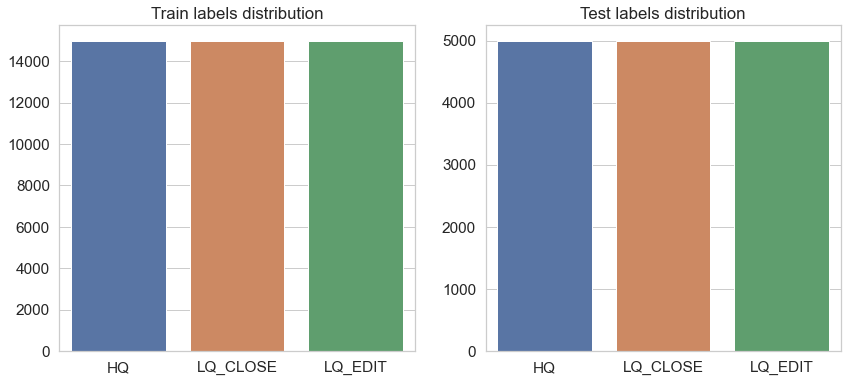

In [6]:
train_Y_vc = train_data['Y'].value_counts()
valid_Y_vc = valid_data['Y'].value_counts()


fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(x=train_Y_vc.index, y=train_Y_vc.values, ax=axes[0])
axes[0].set_title('Train labels distribution')
sns.barplot(x=valid_Y_vc.index, y=valid_Y_vc.values, ax=axes[1])
axes[1].set_title('Test labels distribution')
plt.show()

#### Summary
 - Counts of labels are equal each other for both train and test datasets
 - Train dataset 3x times larger than test

In [7]:
datasets = [('Train', train_data), ('Test', valid_data)]

## Dates distribution

### Days distribution

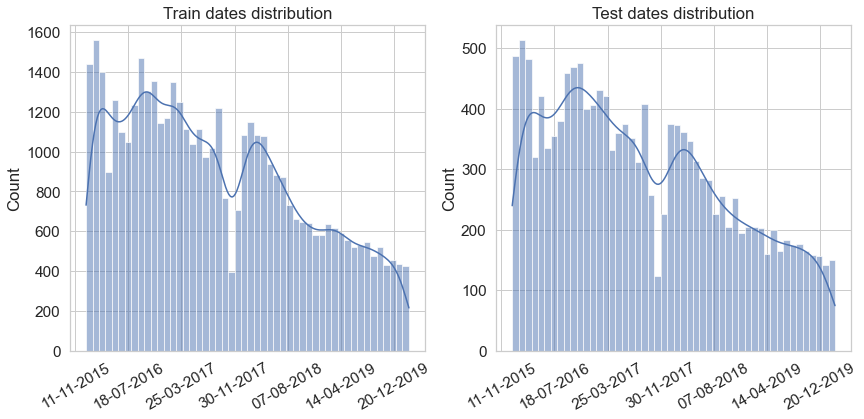

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for idx, (dataset_name, dataset) in enumerate(datasets):
    CD_data = dataset['CreationDate'].sort_values()
    def get_date(arg):
        return arg.date()
    CD_data_mapped = CD_data.map(get_date)
    sns.histplot(x=mdates.date2num(CD_data_mapped), bins=50, kde=True, ax=axes[idx])
    axes[idx].set_title(f'{dataset_name} dates distribution')
    plt.setp(axes[idx].xaxis.get_ticklabels(), rotation=30)
    myFmt = mdates.DateFormatter('%d-%m-%Y')
    axes[idx].xaxis.set_major_formatter(myFmt)
plt.show()

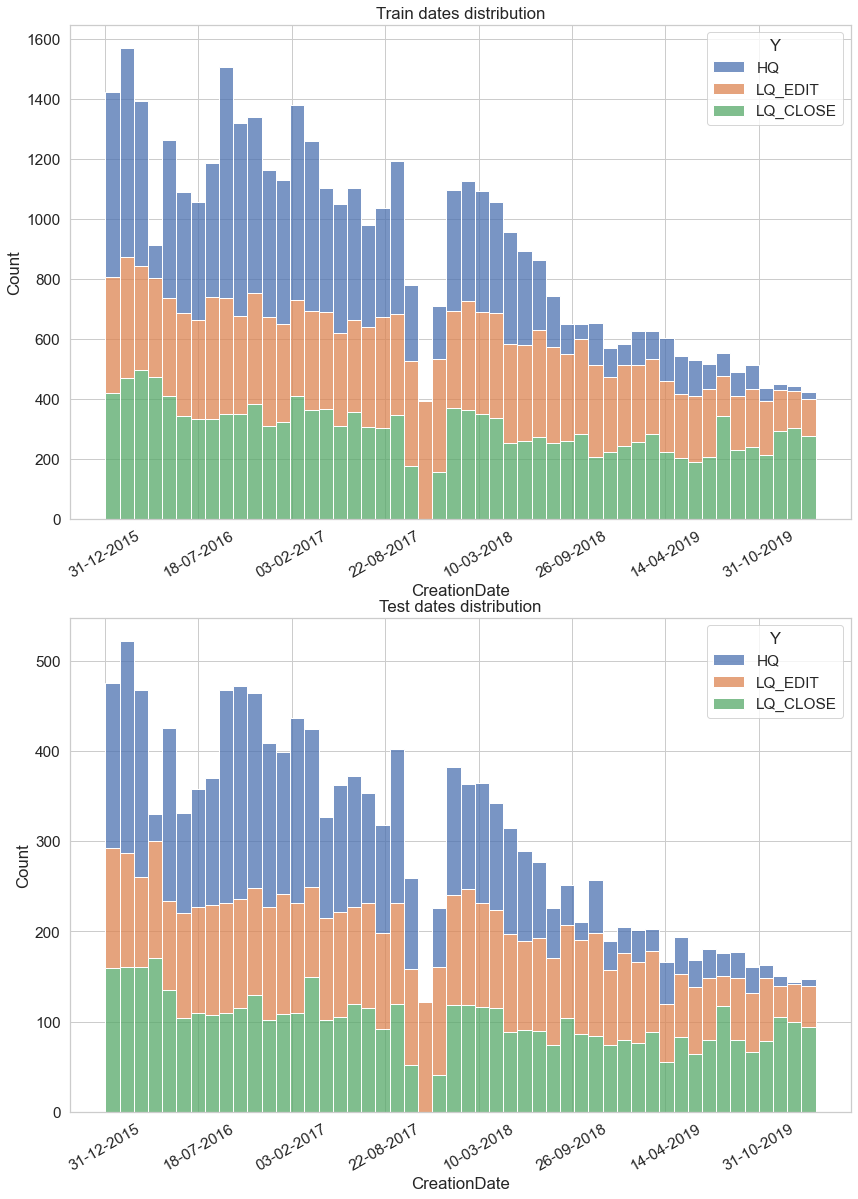

In [9]:
palette = {'HQ': 'C0', 'LQ_EDIT': 'C1', 'LQ_CLOSE': 'C2'}
hue_order = ['HQ', 'LQ_EDIT', 'LQ_CLOSE']
anomaly_timeframes = {}

def search_anomaly_timeframe_bounds(CD_data):
    max_length = 0
    current_length = 0
    is_in_sector = False
    start_sector_idx = None
    max_start_sector_idx = None
    max_finish_sector_idx = None
    CD_data = CD_data.copy()
    for index, row in CD_data.iterrows():
        if row['Y'] == 'LQ_EDIT':
            if is_in_sector:
                current_length += 1
            else:
                is_in_sector = True
                current_length = 1
                start_sector_idx = index
        else:
            if current_length > max_length:
                max_length = current_length
                max_start_sector_idx = start_sector_idx
                max_finish_sector_idx = index
            is_in_sector = False
    return CD_data['CreationDate'][max_start_sector_idx], CD_data['CreationDate'][max_finish_sector_idx]
    
fig, axes = plt.subplots(2, 1, figsize=(14, 20))
for idx, (dataset_name, dataset) in enumerate(datasets):
    CD_data = dataset[['CreationDate', 'Y']].copy()
    CD_data.sort_values(by=['CreationDate'], inplace=True)
    anomaly_timeframes[dataset_name] = search_anomaly_timeframe_bounds(CD_data)
    CD_data['CreationDate'] = mdates.date2num(CD_data['CreationDate'])
    sns.histplot(data=CD_data, x='CreationDate', bins=50, multiple='stack', hue='Y', ax=axes[idx], 
                 palette=palette, hue_order=hue_order)
    axes[idx].set_title(f'{dataset_name} dates distribution')
    plt.setp(axes[idx].xaxis.get_ticklabels(), rotation=30)
    myFmt = mdates.DateFormatter('%d-%m-%Y')
    axes[idx].xaxis.set_major_formatter(myFmt)
plt.show()

In [10]:
print('Timeframes with only LQ_EDIT samples:')
for key, value in anomaly_timeframes.items():
    print(f'{key} dataset : [{value[0]}, {value[1]}]')

Timeframes with only LQ_EDIT samples:
Train dataset : [2017-10-17 08:06:29, 2017-12-15 16:32:28]
Test dataset : [2017-10-17 05:57:57, 2017-12-15 18:01:33]


#### Summary
 - The graphs show the decrease in the number of HQ labels over time
 - Timeframe with only LQ_EDIT exists in both train and test datasets

### Daytimes distribution

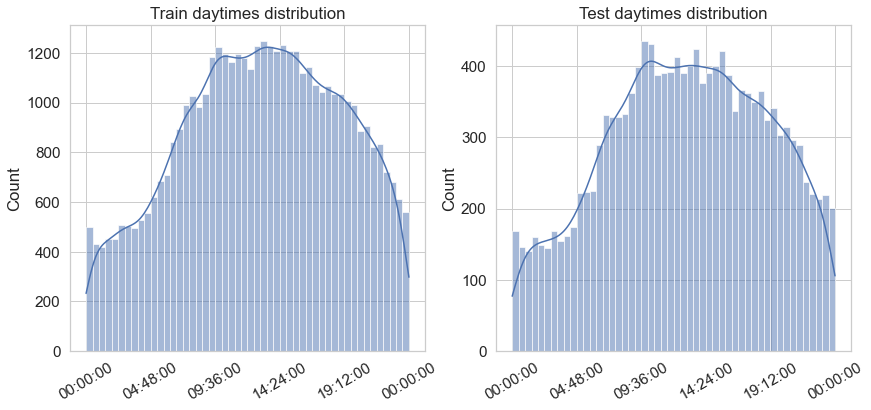

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for idx, (dataset_name, dataset) in enumerate(datasets):
    CD_data = dataset['CreationDate']
    def get_daytime(arg):
        str_time = arg.replace(year=2020, day=1, month=1)
        return str_time
    CD_data_mapped = CD_data.map(get_daytime).sort_values()
    sns.histplot(x=mdates.date2num(CD_data_mapped), bins=50, kde=True, ax=axes[idx])
    axes[idx].set_title(f'{dataset_name} daytimes distribution')
    plt.setp(axes[idx].xaxis.get_ticklabels(), rotation=30)
    myFmt = mdates.DateFormatter('%H:%M:%S')
    axes[idx].xaxis.set_major_formatter(myFmt)
plt.show()

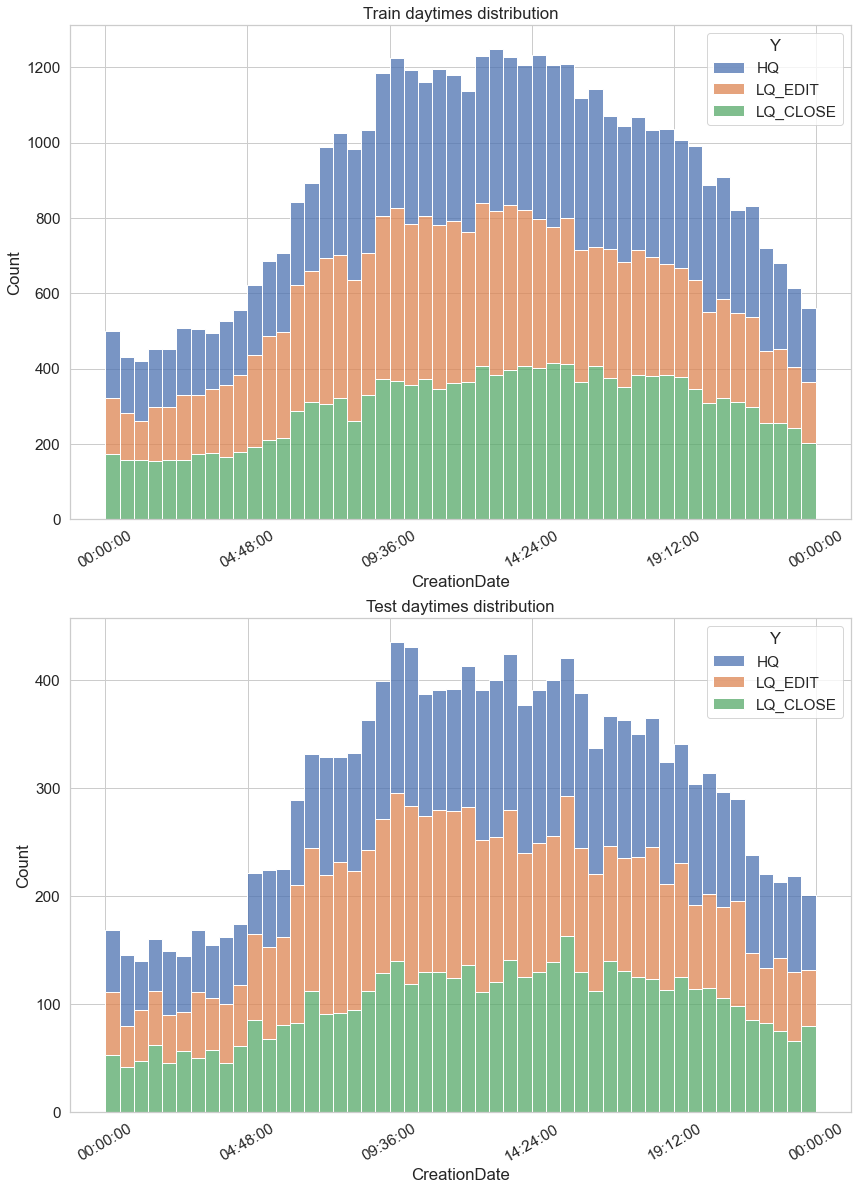

In [12]:
palette = {'HQ': 'C0', 'LQ_EDIT': 'C1', 'LQ_CLOSE': 'C2'}
hue_order = ['HQ', 'LQ_EDIT', 'LQ_CLOSE']

fig, axes = plt.subplots(2, 1, figsize=(14, 20))
for idx, (dataset_name, dataset) in enumerate(datasets):
    CD_data = dataset[['CreationDate', 'Y']].copy()
    def get_daytime(arg):
        str_time = arg.replace(year=2020, day=1, month=1)
        return str_time
    CD_data['CreationDate'] = CD_data['CreationDate'].map(get_daytime)
    CD_data.sort_values(by=['CreationDate'])
    CD_data['CreationDate'] = mdates.date2num(CD_data['CreationDate'])
    sns.histplot(data=CD_data, x='CreationDate', bins=50, multiple='stack', hue='Y', ax=axes[idx],
                palette=palette, hue_order=hue_order)
    axes[idx].set_title(f'{dataset_name} daytimes distribution')
    plt.setp(axes[idx].xaxis.get_ticklabels(), rotation=30)
    myFmt = mdates.DateFormatter('%H:%M:%S')
    axes[idx].xaxis.set_major_formatter(myFmt)
plt.show()

#### Summary
 - No insights

## Tags
### Find intersection of train and test datasets

In [13]:
def get_tags_counts(T_data):
    tags_dict = {}
    for item in T_data:
        if item[0] != '<' or item[-1] != '>':
            logging.error(f'Wrong format of tag: {item}')
        local_tags = item[1:-1].split('><')
        local_tags_set = set()
        for local_tag in local_tags:
            if local_tag in local_tags_set:
                continue
            local_tags_set.add(local_tag)
            if local_tag not in tags_dict.keys():
                tags_dict[local_tag] = 0
            tags_dict[local_tag] += 1
    return dict(sorted(tags_dict.items(), key=lambda item: -item[1]))

tags_dicts = {}
overall_keys = None

for idx, (dataset_name, dataset) in enumerate(datasets):
    T_data = dataset['Tags'].copy()
    tags_counts = get_tags_counts(T_data)
    print(f'Top 5 tags ({dataset_name} dataset):', sorted(tags_counts.items(), key=lambda item: -item[1])[:5])
    print(f'Tags count ({dataset_name} dataset):', len(tags_counts.keys()))
    tags_dicts[dataset_name] = tags_counts
    
overall_keys = tags_dicts['Train'].keys() & tags_dicts['Test'].keys()
print('Size of tags intersection on Train & Test datasets:', 
      len(overall_keys))

Top 5 tags (Train dataset): [('javascript', 5385), ('python', 5041), ('java', 4677), ('android', 3573), ('c#', 3137)]
Tags count (Train dataset): 9336
Top 5 tags (Test dataset): [('python', 1759), ('javascript', 1721), ('java', 1565), ('android', 1265), ('php', 1036)]
Tags count (Test dataset): 5401
Size of tags intersection on Train & Test datasets: 4034


### Get "tag X class" counts

In [14]:
overall_tags = []
overall_tags_df = {}

def init_stage_overall_tags():
    stage_overall_tags = {}
    for key in overall_keys:
        stage_overall_tags[key] = {}
        stage_overall_tags[key]['HQ'] = 0
        stage_overall_tags[key]['LQ_EDIT'] = 0
        stage_overall_tags[key]['LQ_CLOSE'] = 0
    return stage_overall_tags
    
for idx, (dataset_name, dataset) in enumerate(datasets):
    overall_tags.append(init_stage_overall_tags())
    stage_overall_tags = overall_tags[-1]
    T_data = dataset[['Tags', 'Y']].copy()
    for index, row in T_data.iterrows():
        tags = set(row['Tags'][1:-1].split('><'))
        for tag in tags:
            if tag in overall_keys:
                stage_overall_tags[tag][row['Y']] += 1
    overall_tags_df[dataset_name] = pd.DataFrame.from_dict(stage_overall_tags, orient='index')
    print(f'{dataset_name} tags:')
    print(overall_tags_df[dataset_name])
    

Train tags:
                          HQ  LQ_EDIT  LQ_CLOSE
delegates                  1        5         2
addition                   1        0         4
paint                      0        2         0
sap-cloud-platform         0        1         0
constraint-layout-chains   1        0         0
...                       ..      ...       ...
integration-testing        6        0         1
amazon-vpc                 6        1         2
mysql-error-1064           0        3         1
rgb                        0        2         2
sudoku                     0        0         4

[4034 rows x 3 columns]
Test tags:
                          HQ  LQ_EDIT  LQ_CLOSE
delegates                  0        2         2
addition                   0        1         0
paint                      0        1         0
sap-cloud-platform         0        1         0
constraint-layout-chains   1        0         0
...                       ..      ...       ...
integration-testing        6        0   

### Get quantiles of tags counts distribution

In [15]:
for idx, (dataset_name, dataset) in enumerate(datasets):
    def sum_counts(row):
        return sum(row.values[:3])
    tags_counts = overall_tags_df[dataset_name].apply(sum_counts, axis=1)
    overall_tags_df[dataset_name]['Sum'] = tags_counts
    print(overall_tags_df[dataset_name])
    q = tags_counts.quantile(np.linspace(0.9,1,9))
    print(f'{dataset_name} quantiles')
    print(q)

                          HQ  LQ_EDIT  LQ_CLOSE  Sum
delegates                  1        5         2    8
addition                   1        0         4    5
paint                      0        2         0    2
sap-cloud-platform         0        1         0    1
constraint-layout-chains   1        0         0    1
...                       ..      ...       ...  ...
integration-testing        6        0         1    7
amazon-vpc                 6        1         2    9
mysql-error-1064           0        3         1    4
rgb                        0        2         2    4
sudoku                     0        0         4    4

[4034 rows x 4 columns]
Train quantiles
0.9000      32.0000
0.9125      37.0000
0.9250      45.0000
0.9375      55.9375
0.9500      71.0000
0.9625      95.7625
0.9750     154.0000
0.9875     282.7625
1.0000    5385.0000
dtype: float64
                          HQ  LQ_EDIT  LQ_CLOSE  Sum
delegates                  0        2         2    4
addition              

### Summary
 - Most part of tags appear rare. Others appear very often.

### Get good & rare tags

In [16]:
# Drop extra tags for visualization. count_limit provide opportunity to drop rare tags.
count_limit = 200

local_train_data = overall_tags_df['Train']
good_tags_index = local_train_data[local_train_data['Sum'] > count_limit]
rare_tags_index = local_train_data[local_train_data['Sum'] <= count_limit]
print('Good tags')
print(good_tags_index)
print('Tags at all:', sum(good_tags_index['Sum'].values))
good_tags_index = good_tags_index.index
print()
print('Rare tags')
print(rare_tags_index)
print('Tags at all:', sum(rare_tags_index['Sum'].values))
rare_tags_index = rare_tags_index.index

Good tags
                     HQ  LQ_EDIT  LQ_CLOSE   Sum
asp.net              99      137       115   351
list                 35      198       191   424
visual-studio-code  208        8         9   225
c                    65      572       746  1383
sql                  63      878       302  1243
...                 ...      ...       ...   ...
android-studio      174       98       119   391
.net                161      114       158   433
ruby                 67      211        98   376
function             21      121       142   284
if-statement          3      106       109   218

[75 rows x 4 columns]
Tags at all: 63413

Rare tags
                          HQ  LQ_EDIT  LQ_CLOSE  Sum
delegates                  1        5         2    8
addition                   1        0         4    5
paint                      0        2         0    2
sap-cloud-platform         0        1         0    1
constraint-layout-chains   1        0         0    1
...                       ..   

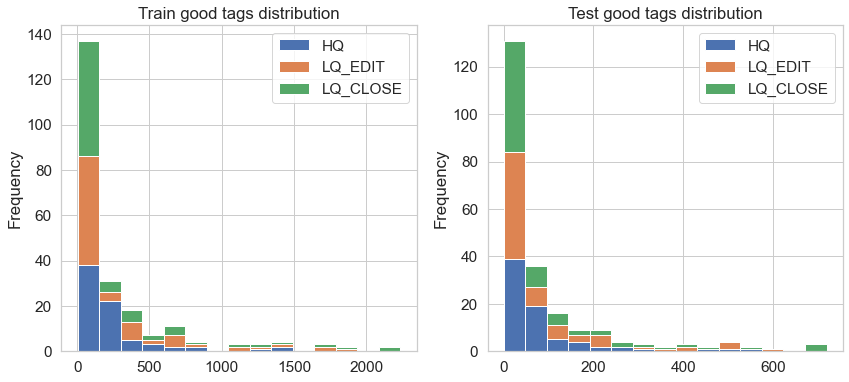

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for idx, (dataset_name, dataset) in enumerate(datasets):
    local_tags = overall_tags_df[dataset_name].copy().drop(['Sum'], axis=1)
    tags_x_class = local_tags.loc[good_tags_index]
    tags_x_class.plot.hist(bins=15, stacked='True', title=f'{dataset_name} good tags distribution', ax=axes[idx])

In [18]:
good_tags_index

Index(['asp.net', 'list', 'visual-studio-code', 'c', 'sql', 'algorithm',
       'jquery', 'go', 'windows', 'django', 'linux', 'date', 'vba', 'oracle',
       'kotlin', 'spring-boot', 'ruby-on-rails', 'html', 'amazon-web-services',
       'node.js', 'wordpress', 'laravel', 'ios', 'python', 'loops', 'java',
       'xcode', 'reactjs', 'android', 'python-2.7', 'docker', 'flutter',
       'mysql', 'excel', 'string', 'dictionary', 'xml', 'swift', 'firebase',
       'tensorflow', 'json', 'git', 'php', 'vue.js', 'angularjs', 'angular',
       'react-native', 'sorting', 'asp.net-core', 'javascript', 'c++',
       'objective-c', 'pandas', 'r', 'asp.net-mvc', 'regex', 'database', 'c#',
       'ajax', 'selenium', 'python-3.x', 'typescript', 'sql-server', 'webpack',
       'bash', 'arrays', 'visual-studio', 'spring', 'for-loop', 'css',
       'android-studio', '.net', 'ruby', 'function', 'if-statement'],
      dtype='object')

### Analyse rare tags with Gini coef
https://en.wikipedia.org/wiki/Gini_coefficient

In [19]:
def gini_coef(coefs):
    s = sum(coefs)
    arith_mean = s / len(coefs)
    acc = 0
    for i in coefs:
        for j in coefs:
            acc += abs(i - j)
    acc /= (2 * len(coefs) ** 2 * arith_mean)
    return acc

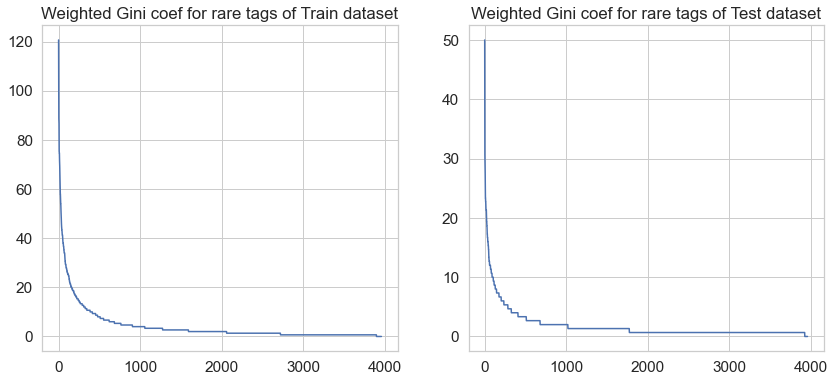

In [20]:
# To prevent overfitting on very-very rare tags we'll multiply Gini coef on sum of coefs
def weighted_gini_coef(coefs):
    return gini_coef(coefs) * sum(coefs)

rare_tags = {}

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for idx, (dataset_name, dataset) in enumerate(datasets):
    local_tags = overall_tags_df[dataset_name].copy().drop(['Sum'], axis=1)
    tags_x_class = local_tags.loc[rare_tags_index]
    rare_tags_scores = tags_x_class.apply(weighted_gini_coef, axis=1).sort_values(ascending=False)
    sns.lineplot(data=rare_tags_scores.values, ax=axes[idx])
    axes[idx].set_title(f'Weighted Gini coef for rare tags of {dataset_name} dataset')
    rare_tags[dataset_name] = rare_tags_scores

### Analyze Train over Test Gini coef relations

In [21]:
def analyze_gini_relations(count_limit=1e9):
    gini_relations = []
    fig, ax = plt.subplots(figsize=(7, 6))
    print('Actual train Gini coefs')
    print(rare_tags['Train'])
    limit_idx = 0
    for tag in rare_tags['Train'].index:
        if limit_idx >= count_limit:
            break
        limit_idx += 1
        train_tag_scores = rare_tags['Train'].loc[tag]
        test_tag_scores = rare_tags['Test'].loc[tag]
        if (train_tag_scores != 0 and test_tag_scores != 0):
            gini_relations.append(train_tag_scores / test_tag_scores)
    sns.scatterplot(data=gini_relations, ax=ax, alpha=0.7)
    print()
    print('Quantiles')
    print(pd.DataFrame(gini_relations).quantile([0.1, 0.25, 0.5, 0.75, 0.9, 1]))
    return 

Actual train Gini coefs
dart            120.666667
npm             102.666667
.net-core        91.333333
kubernetes       88.666667
vb.net           87.333333
                   ...    
mp3               0.000000
diagram           0.000000
nonetype          0.000000
std-function      0.000000
sigabrt           0.000000
Length: 3959, dtype: float64

Quantiles
             0
0.10  2.393429
0.25  2.651116
0.50  3.161458
0.75  3.684028
0.90  4.107237
1.00  6.833333


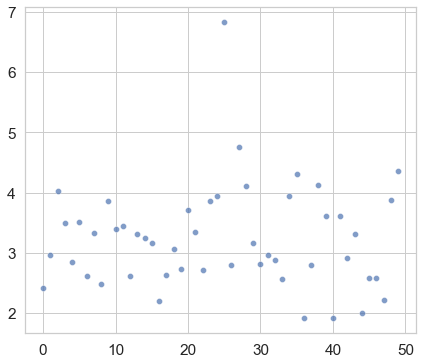

In [22]:
analyze_gini_relations(50)

### Summary
 - At least first 50 rare tags have non-uniform distribution on classes (for both train and test datasets)

Actual train Gini coefs
dart            120.666667
npm             102.666667
.net-core        91.333333
kubernetes       88.666667
vb.net           87.333333
                   ...    
mp3               0.000000
diagram           0.000000
nonetype          0.000000
std-function      0.000000
sigabrt           0.000000
Length: 3959, dtype: float64

Quantiles
              0
0.10   2.191234
0.25   2.587010
0.50   3.177083
0.75   3.866477
0.90   4.516667
1.00  15.333333


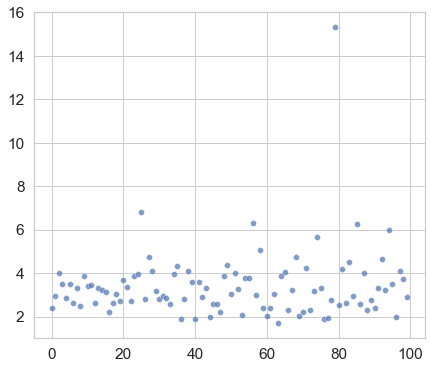

In [23]:
analyze_gini_relations(100)

Actual train Gini coefs
dart            120.666667
npm             102.666667
.net-core        91.333333
kubernetes       88.666667
vb.net           87.333333
                   ...    
mp3               0.000000
diagram           0.000000
nonetype          0.000000
std-function      0.000000
sigabrt           0.000000
Length: 3959, dtype: float64

Quantiles
         0
0.10   1.0
0.25   1.0
0.50   2.0
0.75   3.0
0.90   4.5
1.00  26.0


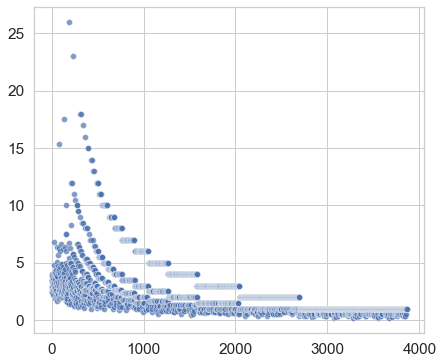

In [24]:
analyze_gini_relations()

In [25]:
interesting_rare_indices = rare_tags['Train'].index[:50]

In [26]:
interesting_rare_indices

Index(['dart', 'npm', '.net-core', 'kubernetes', 'vb.net', 'gradle',
       'ecmascript-6', 'macos', 'intellij-idea', 'docker-compose', 'winforms',
       'unit-testing', 'redux', 'google-chrome', 'jenkins', 'tsql', 'pointers',
       'keras', 'perl', 'vuejs2', 'math', 'postgresql', 'github', 'batch-file',
       'visual-studio-2017', 'apache-spark', 'object', 'numpy', 'variables',
       'class', 'swiftui', 'dockerfile', 'mysqli', 'file', 'rxjs', 'c++17',
       'azure', 'arraylist', 'jupyter-notebook', 'angular-cli', 'web', 'csv',
       'amazon-s3', 'matlab', 'sqlite', 'mongodb', 'wpf', 'codeigniter',
       'swift3', 'random'],
      dtype='object')

## Bodies

In [27]:
def remove_html_tags(text):
    html_detector = re.compile(r'<.*?>')
    return html_detector.sub(r'', text)

def remove_links(text):
    links_remover = re.compile(r'https?://\S+|www\.\S+')
    return links_remover.sub(r'', text)

#split_symbols = '\n| |{|}|\(|\)|\[|\]|\,|\.|\[^e]-[^0-9]|\=|\+|\*|\?'
split_symbols = r'[^A-Za-z\']'

def preprocess_body(body):
    body = remove_html_tags(body)
    body = remove_links(body)
    body = body.replace('&gt;', '>').replace('&lt;', '<').replace('&le;', '<=').replace('&ge;', '>=')
    splitted = re.split(split_symbols, body)
    result = []
    for part in splitted:
        if len(part.strip()) > 0:
            result.append(part)
    return result

def preprocess_title(title):
    title = remove_links(title)
    splitted = re.split(split_symbols, title)
    result = []
    for part in splitted:
        if len(part.strip()) > 0:
            result.append(part)
    return result

In [28]:
bodies = {}
titles = {}
label_map={'HQ': 0, 'LQ_EDIT': 1, 'LQ_CLOSE': 2}
reverse_label_map={0: 'HQ', 1: 'LQ_EDIT', 2: 'LQ_CLOSE'}

for idx, (dataset_name, dataset) in enumerate(datasets):
    bodies[dataset_name] = {}
    titles[dataset_name] = {}
    for idx, row in dataset.iterrows():
        processed_body = preprocess_body(row['Body'])
        processed_title = preprocess_title(row['Title'])
        if len(processed_body) == 0 or len(processed_title) == 0:
            continue
        bodies[dataset_name][idx] = (processed_body, label_map[row['Y']])
        titles[dataset_name][idx] = (processed_title, label_map[row['Y']])
            

### Lengths

In [29]:
palette = {'HQ': 'C0', 'LQ_EDIT': 'C1', 'LQ_CLOSE': 'C2'}
hue_order = ['HQ', 'LQ_EDIT', 'LQ_CLOSE']

Quantiles Train
      Lengths
0.10    29.00
0.25    46.00
0.50    78.00
0.75   133.00
0.99   672.04
1.00  4397.00
Quantiles Test
      Lengths
0.10    30.00
0.25    46.00
0.50    78.00
0.75   134.00
0.99   690.02
1.00  4839.00


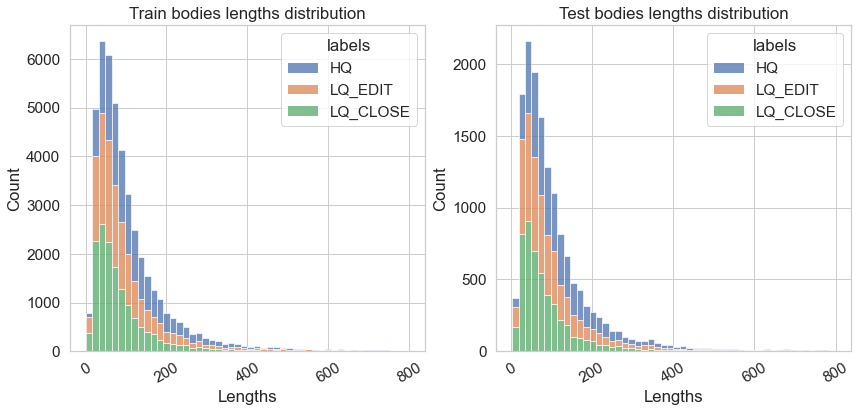

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
target_dict = bodies

for idx, (dataset_name, dataset) in enumerate(datasets):
    lengths = []
    labels = []
    for key, value in target_dict[dataset_name].items():
        lengths.append(len(value[0]))
        labels.append(reverse_label_map[value[1]])
    df = pd.DataFrame(data={'Lengths': lengths, 'labels': labels})
    print(f'Quantiles {dataset_name}')
    print(df.quantile([0.1, 0.25, 0.5, 0.75, 0.99, 1]))
    df = df[df['Lengths'] < 800]
    sns.histplot(data=df, x='Lengths', bins=50, multiple='stack', hue='labels', ax=axes[idx],
                palette=palette, hue_order=hue_order)
    axes[idx].set_title(f'{dataset_name} bodies lengths distribution')
    plt.setp(axes[idx].xaxis.get_ticklabels(), rotation=30)

Quantiles
      Lengths
0.10      5.0
0.25      6.0
0.50      9.0
0.75     11.0
0.99     23.0
1.00     35.0
Quantiles
      Lengths
0.10      5.0
0.25      6.0
0.50      8.0
0.75     11.0
0.99     23.0
1.00     34.0


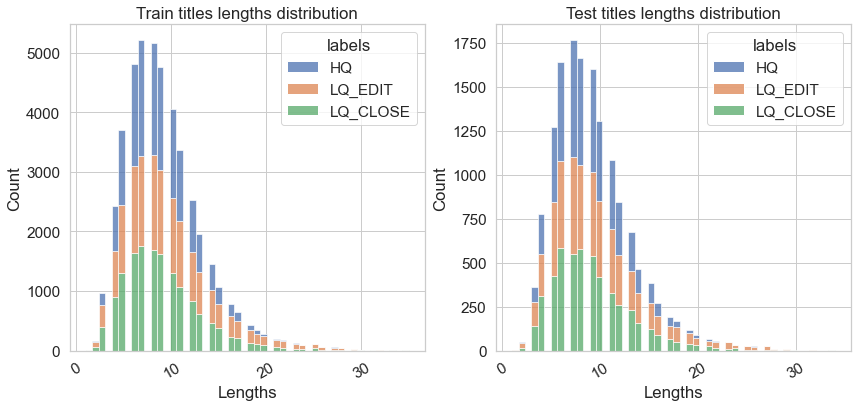

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
target_dict = titles

for idx, (dataset_name, dataset) in enumerate(datasets):
    lengths = []
    labels = []
    for key, value in target_dict[dataset_name].items():
        lengths.append(len(value[0]))
        labels.append(reverse_label_map[value[1]])
    df = pd.DataFrame(data={'Lengths': lengths, 'labels': labels})
    print('Quantiles')
    print(df.quantile([0.1, 0.25, 0.5, 0.75, 0.99, 1]))
    df = df[df['Lengths'] < 40]
    sns.histplot(data=df, x='Lengths', bins=50, multiple='stack', hue='labels', ax=axes[idx],
                palette=palette, hue_order=hue_order)
    axes[idx].set_title(f'{dataset_name} titles lengths distribution')
    plt.setp(axes[idx].xaxis.get_ticklabels(), rotation=30)

## Torch configuration

In [32]:
print(*torch.__config__.show().split("\n"), sep="\n")

PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.5.2 (Git Hash a9302535553c73243c632ad3c4c80beec3d19a1e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 10.2
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70
  - CuDNN 7.6.5
  - Magma 2.5.2
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=10.2, CUDNN_VERSION=7.6.5, CXX_COMPILER=/opt/rh/devtoolset-7/root/usr/bin/c++, CXX_FLAGS= -Wno-deprecated -fvisibility-inlines-hidden -DUSE_PTHREADPOOL -fopenmp -DNDEBUG -DUSE_KINETO -DUSE_FBGEMM -DUSE_QNNPACK -DUSE_PYTORCH_QNNPACK -DUSE_XNNPACK -DSYMBOLICATE_MOBILE_DEBUG_HANDLE -DEDGE_PROFILER_USE_KINETO -O2 -fPI

In [33]:
torch.backends.cudnn.is_available()

True

In [34]:
torch.backends.mkldnn.is_available()

True

In [35]:
if torch.cuda.is_available():
    print(torch.cuda.device_count())

1


In [36]:
device = torch.device("cpu")
compute_device = torch.device("cpu")
dtype = torch.float32

## Words converter for NN

In [37]:
def get_empty_word(shape, device):
    return torch.zeros(shape, dtype=dtype, device=device)

def fill_text_data(sentence_tensor, text, limit, embeddings, empty_word, dtype, device):    
    words_added = 0
    word_idx = 0
    while words_added < limit:
        if word_idx >= len(text):
            break
        word = text[word_idx]
        word_idx += 1
        if word in embeddings:
            embedding = embeddings[word]
        else:
            continue
        sentence_tensor.append(torch.tensor(embedding, dtype=dtype, device=device))
        words_added += 1
    extra_limit = limit - words_added
    for word_idx in range(extra_limit):
        sentence_tensor.append(empty_word)

number_body_words_to_add = 100
number_title_words_to_add = 15
        
def get_sentence_tensor(title, body, embeddings, empty_word, title_size, body_size, dtype, device):
    sentence_tensor = []
    fill_text_data(sentence_tensor, title, title_size, embeddings, empty_word, dtype, device)
    fill_text_data(sentence_tensor, body, body_size, embeddings, empty_word, dtype, device)
    return torch.stack(sentence_tensor, dim=0).to(device=device)

def find_sentence_statistics(corpus, embeddings):
    lengths = []
    for item in corpus.values():
        sentence = item[0]
        words_counter = 0
        for word in sentence:
            if word in embeddings:
                words_counter += 1
        lengths.append(words_counter)
    return max(lengths), sum(lengths) / len(lengths)

def get_tags_tensor(dataset, idx, tags_list, dtype):
    local_tags_str = dataset['Tags'].iloc[idx]
    local_tags = set(local_tags_str[1:-1].split('><'))
    tensor_line = np.zeros(len(tags_list), dtype=np.float32)
    for tag_idx, tag in enumerate(tags_list):
        tensor_line[tag_idx] = 1. if tag in local_tags else 0.
    return torch.tensor(tensor_line, dtype=dtype, device=device)
    
def get_time_tensor(dataset, idx, dtype):
    item = dataset['CreationDate'].iloc[idx]
    return torch.tensor([item.timestamp()], dtype=dtype, device=device)

# sentences 
#   label_words
#   body_words
def prepare_data_tensors(dataset, titles, bodies, dtype, device, embeddings, good_tags_index, interesting_rare_indices, forced_limits=None):
    with torch.no_grad():
        tags_list = list(set.union(set(good_tags_index), set(interesting_rare_indices)))
        torch_data_list = []
        torch_labels_list = []
        extra_datas = []
        empty_word = get_empty_word(embeddings['car'].shape, device)
        title_max_length, title_avg_length = find_sentence_statistics(titles, embeddings)
        print(f'Title max length: {title_max_length}, Title avg length: {title_avg_length}')
        body_max_length, body_avg_length = find_sentence_statistics(bodies, embeddings)
        print(f'Body max length: {body_max_length}, Body avg length: {body_avg_length}')
        if not forced_limits:
            title_size = min(number_title_words_to_add, title_max_length)
            body_size = min(number_body_words_to_add, body_max_length)
        else:
            title_size = forced_limits['title_size']
            body_size = forced_limits['body_size']
        for idx in bodies.keys():
            sentence_tensor = get_sentence_tensor(titles[idx][0], bodies[idx][0], embeddings, empty_word, title_size, body_size, dtype, device)
            tags_tensor = get_tags_tensor(dataset, idx, tags_list, dtype)
            time_tensor = get_time_tensor(dataset, idx, dtype)
            extra_data = torch.cat([tags_tensor, time_tensor])
            extra_datas.append(extra_data)
            # print(f'SHAPE: {sentence_tensor.shape}')
            torch_data_list.append(sentence_tensor)
            torch_labels_list.append(bodies[idx][1])
    return torch.stack(torch_data_list, dim=0).to(device=device), \
            torch.stack(extra_datas, dim=0).to(device=device), \
            torch.tensor(torch_labels_list, dtype=torch.long, device=device), \
            title_size, body_size

## Bidirectional RNN Model with FC head

In [38]:
import time

class RNNModel(nn.Module):
    def __init__(self, embeddings, compute_device, *, title_size, body_size, output_size, hidden_dim, embedding_dim, extra_size):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embeddings = embeddings
        self.compute_device = compute_device
        self.output_size = output_size
        self.embedding_dim = embedding_dim
        self.title_size = title_size
        self.body_size = body_size
        self.extra_size = extra_size
        self.lstm_forward_title = nn.LSTMCell(self.embedding_dim, self.hidden_dim)
        self.lstm_backward_title = nn.LSTMCell(self.embedding_dim, self.hidden_dim)
        self.lstm_forward_body = nn.LSTMCell(self.embedding_dim, self.hidden_dim)
        self.lstm_backward_body = nn.LSTMCell(self.embedding_dim, self.hidden_dim)
        self.maxpool = nn.AdaptiveMaxPool1d(1)
        self.input_size = self.hidden_dim * 4 + self.extra_size
        self.batchnorm = nn.BatchNorm1d(self.input_size)
        self.fc1_1 = nn.Linear(self.input_size, self.output_size)
        self.fc1_2 = nn.Linear(self.input_size, self.output_size)
        self.fc1_3 = nn.Linear(self.input_size, self.output_size)
        self.prelu1 = nn.PReLU()
        self.prelu2 = nn.PReLU()
        self.prelu3 = nn.PReLU()
        self.fc2_1 = nn.Linear(self.output_size, 1)
        self.fc2_2 = nn.Linear(self.output_size, 1)
        self.fc2_3 = nn.Linear(self.output_size, 1)
        self.softmax = nn.Softmax(dim=1)

    def _get_hidden_state_for_words(self, lstm_cell, data, iterable_idx, hx_init, cx_init):
        hx = hx_init.detach().clone()
        cx = cx_init.detach().clone()
        hx_copies = [hx]
        for idx in iterable_idx:
            subdata = data[idx]
            hx, cx = lstm_cell(subdata, (hx, cx))
            hx_copies.append(hx)
        return torch.stack(hx_copies, dim=2)
    
    def _eval_part_of_hidden(self, data, hx_init, cx_init, iterable_idx, fwd_lstm_cell, bkwd_lstm_cell):
        forward_pass = self._get_hidden_state_for_words(fwd_lstm_cell, data, iterable_idx, hx_init, cx_init)
        forward_pooled = self.maxpool(forward_pass).view(-1, self.hidden_dim)
        backward_pass = self._get_hidden_state_for_words(bkwd_lstm_cell, data, reversed(iterable_idx), hx_init, cx_init)
        backward_pooled = self.maxpool(backward_pass).view(-1, self.hidden_dim)
        concat_pass = torch.cat([forward_pooled, backward_pooled], dim=1)
        return concat_pass
    
    def _eval_hidden(self, data, hx_init, cx_init):
        title_iterable_id = range(self.title_size)
        title_pass = self._eval_part_of_hidden(data, hx_init, cx_init, title_iterable_id, self.lstm_forward_title, self.lstm_backward_title)
        body_start_idx = self.title_size
        body_iterable_id = range(body_start_idx, body_start_idx + self.body_size)
        body_pass = self._eval_part_of_hidden(data, hx_init, cx_init, title_iterable_id, self.lstm_forward_body, self.lstm_backward_body)
        concat_pass = torch.cat([title_pass, body_pass], dim=1)
        return concat_pass

    # X - [batch_size, words_num, embed_dim]
    def forward(self, data, extra):
        data = torch.transpose(data, 0, 1)
        hx_init = torch.zeros(data.shape[1], self.hidden_dim, dtype=dtype, device=self.compute_device)
        cx_init = torch.zeros(data.shape[1], self.hidden_dim, dtype=dtype, device=self.compute_device)
        hidden_result = self._eval_hidden(data, hx_init, cx_init)
        
#         print('extra shape', extra.shape)
        cat_input_linear = torch.cat([hidden_result, extra], dim=1)
#         print('cat_input_linear shape', cat_input_linear.shape)
        normalized = self.batchnorm(cat_input_linear)
#         print('normalized shape', normalized.shape)
        
        fc1_1_res = self.fc1_1(normalized)
        fc1_2_res = self.fc1_2(normalized)
        fc1_3_res = self.fc1_3(normalized)
        
        prelu1_res = self.prelu1(fc1_1_res)
        prelu2_res = self.prelu2(fc1_2_res)
        prelu3_res = self.prelu3(fc1_3_res)
        
        fc2_1_res = self.fc2_1(prelu1_res)
        fc2_2_res = self.fc2_2(prelu2_res)
        fc2_3_res = self.fc2_3(prelu3_res)
        head_res = torch.cat([fc2_1_res, fc2_2_res, fc2_3_res], 1)
        softmax_res = self.softmax(head_res)
        return softmax_res


## Train function definition

In [88]:
def evaluate(data, extra, labels, model, criterion, compute_device, batch_indices, metrics, metrics_stage):
    auroc = AUROC(num_classes=3, average='macro')
    accuracy = Accuracy(num_classes=3, average='macro')
    f1score = F1Score(num_classes=3, average='macro')
    local_loss = []
    local_metrics_aucroc = []
    local_metrics_accuracy = []
    local_metrics_f1score = []
    for batch_idx, batch_indices in enumerate(batch_indices):
        batch_data = data[batch_indices].to(compute_device)
        batch_extra = extra[batch_indices].to(compute_device)
        batch_labels = labels[batch_indices].to(compute_device)
        predicted = model.forward(batch_data, batch_extra)
        loss = criterion(predicted, batch_labels)
        local_loss.append(loss.item())
        local_metrics_aucroc.append(auroc(predicted, batch_labels).item())
        local_metrics_accuracy.append(accuracy(predicted, batch_labels).item())
        local_metrics_f1score.append(f1score(predicted, batch_labels).item())
        del batch_data, batch_extra, batch_labels, predicted, loss
        gc.collect()
        torch.cuda.empty_cache()
    metrics[metrics_stage]['loss'].append(sum(local_loss) / len(local_loss))
    metrics[metrics_stage]['aucroc'].append(sum(local_metrics_aucroc) / len(local_metrics_aucroc))
    metrics[metrics_stage]['accuracy'].append(sum(local_metrics_accuracy) / len(local_metrics_accuracy))
    metrics[metrics_stage]['f1score'].append(sum(local_metrics_f1score) / len(local_metrics_f1score))
    
def get_latest_metrics(metrics):
    latest_metrics = {}
    for stage in ('train', 'test'):
        latest_metrics[stage] = {}
        for key, value in metrics[stage].items():
            latest_metrics[stage][key] = f'{metrics[stage][key][-1]:.3f}'
    return latest_metrics

def train(torch_train_data, torch_train_extra, torch_train_labels, 
          torch_test_data, torch_test_extra, torch_test_labels, 
          model_class, embeddings, epoch_count, batch_size, device, compute_device, dtype, **kwargs):
    model = model_class(embeddings, compute_device, **kwargs).to(compute_device)
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    logging.info('Model was created.')
    
    import time
    
    batches_count = torch_train_data.shape[0] // batch_size
    if torch_train_data.shape[0] % batch_size:
        batches_count += 1
    metrics = {
        'train' : {
            'loss' : [],
            'aucroc' : [],
            'accuracy' : [],
            'f1score' : []
        },
        'test' : {
            'loss' : [],
            'aucroc' : [],
            'accuracy' : [],
            'f1score' : []
        }
    }
    
    # Test on test data
    test_batch_size = 4096
    test_perm_indices = list(BatchSampler(RandomSampler(range(torch_test_data.shape[0])), 
                                     batch_size=test_batch_size, drop_last=True))
    start_test1 = time.time()
    evaluate(torch_test_data, torch_test_extra, torch_test_labels, 
             model, criterion, compute_device, test_perm_indices, metrics, 'test')
    end_test1 = time.time()

    # Test on train data
    train_batch_size = 4096
    train_perm_indices = list(BatchSampler(RandomSampler(range(torch_train_data.shape[0])), 
                                     batch_size=train_batch_size, drop_last=True))
    start_test1 = time.time()
    evaluate(torch_train_data, torch_train_extra, torch_train_labels, 
             model, criterion, compute_device, train_perm_indices, metrics, 'train')
    end_test1 = time.time()
    logging.info(f'Initial metrics prepared. Metrics: {get_latest_metrics(metrics)}.')
    
    gc.collect()
    torch.cuda.empty_cache()
    
    for epoch in range(epoch_count):
        logging.info(f'Epoch {epoch}/{epoch_count} started.')
        
        # Train loop
        perm_indices = list(BatchSampler(RandomSampler(range(torch_train_data.shape[0])), 
                                         batch_size=batch_size, drop_last=True))
        start_tr1 = time.time()
        for batch_idx, batch_indices in enumerate(perm_indices):
            batch_data = torch_train_data[batch_indices].to(compute_device)
            batch_extra = torch_train_extra[batch_indices].to(compute_device)
            batch_labels = torch_train_labels[batch_indices].to(compute_device)
            optimizer.zero_grad()
            predicted = model.forward(batch_data, batch_extra)
            loss = criterion(predicted, batch_labels)
            loss.backward()
            optimizer.step()            
            del batch_data, batch_labels, batch_extra, predicted, loss
            gc.collect()
            torch.cuda.empty_cache()
        end_tr1 = time.time()
        
        # Test on test data
        test_batch_size = 4096
        test_perm_indices = list(BatchSampler(RandomSampler(range(torch_test_data.shape[0])), 
                                         batch_size=test_batch_size, drop_last=True))
        start_test1 = time.time()
        evaluate(torch_test_data, torch_test_extra, torch_test_labels, 
                 model, criterion, compute_device, test_perm_indices, metrics, 'test')
        end_test1 = time.time()
        
        # Test on train data
        train_batch_size = 4096
        train_perm_indices = list(BatchSampler(RandomSampler(range(torch_train_data.shape[0])), 
                                         batch_size=train_batch_size, drop_last=True))
        start_test1 = time.time()
        evaluate(torch_train_data, torch_train_extra, torch_train_labels, 
                 model, criterion, compute_device, train_perm_indices, metrics, 'train')
        end_test1 = time.time()
        gc.collect()
        torch.cuda.empty_cache()
        logging.info(f'Epoch {epoch} finished. Metrics: {get_latest_metrics(metrics)}.')
    return model, metrics


## Train Bidirectional RNN Model with FC head (Glove embeddings)

In [40]:
embeddings = gensim.downloader.load('glove-twitter-100')

INFO:gensim.models.keyedvectors:loading projection weights from /home/masdevas/gensim-data/glove-twitter-100/glove-twitter-100.gz
INFO:gensim.utils:KeyedVectors lifecycle event {'msg': 'loaded (1193514, 100) matrix of type float32 from /home/masdevas/gensim-data/glove-twitter-100/glove-twitter-100.gz', 'binary': False, 'encoding': 'utf8', 'datetime': '2022-04-15T10:09:43.155029', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 16 2021, 13:09:58) \n[GCC 7.5.0]', 'platform': 'Linux-5.13.0-39-generic-x86_64-with-glibc2.31', 'event': 'load_word2vec_format'}


In [62]:
hidden_dim = 50
output_size = 125
embedding_dim = 100
epoch_count = 200
batch_size = 1024
extra_size = 126

In [42]:
torch_train_data, torch_train_extra, torch_train_labels, title_size, body_size = prepare_data_tensors(train_data, titles['Train'], bodies['Train'], dtype, device, embeddings, good_tags_index, interesting_rare_indices)
logging.info('Train data was prepared.')

Title max length: 32, Title avg length: 6.935862390826055
Body max length: 2968, Body avg length: 87.12058581683223


INFO:root:Train data was prepared.


In [43]:
torch_test_data, torch_test_extra, torch_test_labels, _, _ = prepare_data_tensors(train_data, titles['Test'], bodies['Test'], dtype, device, embeddings, good_tags_index, interesting_rare_indices, forced_limits={'title_size' : title_size, 'body_size' : body_size})
logging.info('Test data was prepared.')

Title max length: 31, Title avg length: 6.925128341889459
Body max length: 4427, Body avg length: 88.17801186745783


INFO:root:Test data was prepared.


In [ ]:
rnn_model, rnn_metrics = train(torch_train_data, torch_train_extra, torch_train_labels, torch_test_data, torch_test_extra,
      torch_test_labels, RNNModel, embeddings, epoch_count, batch_size, device, compute_device, dtype,
      title_size=title_size, body_size=body_size, output_size=output_size, hidden_dim=hidden_dim, 
      embedding_dim=embedding_dim, extra_size=extra_size)

INFO:root:Model was created.
INFO:root:Initial metrics prepared. Metrics: {'train': {'loss': '1.102', 'aucroc': '0.487', 'accuracy': '0.332', 'f1score': '0.312'}, 'test': {'loss': '1.103', 'aucroc': '0.484', 'accuracy': '0.331', 'f1score': '0.310'}}.
INFO:root:Epoch 0/200 started.


In [54]:
del torch_train_data, torch_train_labels,torch_test_data, torch_test_labels
torch.cuda.empty_cache()
gc.collect()

43

In [53]:
 = model, model_train_losses, model_test_metrics

## Bidirectional RNN Model with RandomForest/kNN head

In [ ]:
# class RNNModel(nn.Module):
#     def __init__(self, embeddings, compute_device, *, title_size, body_size, output_size, hidden_dim, embedding_dim):
#         super().__init__()
#         self.hidden_dim = hidden_dim
#         self.embeddings = embeddings
#         self.compute_device = compute_device
#         self.output_size = output_size
#         self.embedding_dim = embedding_dim
#         self.title_size = title_size
#         self.body_size = body_size
#         self.lstm_forward_title = nn.LSTMCell(self.embedding_dim, self.hidden_dim)
#         self.lstm_backward_title = nn.LSTMCell(self.embedding_dim, self.hidden_dim)
#         self.lstm_forward_body = nn.LSTMCell(self.embedding_dim, self.hidden_dim)
#         self.lstm_backward_body = nn.LSTMCell(self.embedding_dim, self.hidden_dim)
#         self.maxpool = nn.AdaptiveMaxPool1d(1)
#         self.input_size = self.hidden_dim * 4
#         self.batchnorm = nn.BatchNorm1d(self.input_size)
#         self.fc1_1 = nn.Linear(self.input_size, self.output_size)
#         self.fc1_2 = nn.Linear(self.input_size, self.output_size)
#         self.fc1_3 = nn.Linear(self.input_size, self.output_size)
#         self.prelu1 = nn.PReLU()
#         self.prelu2 = nn.PReLU()
#         self.prelu3 = nn.PReLU()
#         self.fc2_1 = nn.Linear(self.output_size, 1)
#         self.fc2_2 = nn.Linear(self.output_size, 1)
#         self.fc2_3 = nn.Linear(self.output_size, 1)
#         self.softmax = nn.Softmax(dim=1)

#     def _get_hidden_state_for_words(self, lstm_cell, data, iterable_idx, hx_init, cx_init):
#         hx = hx_init.detach().clone()
#         cx = cx_init.detach().clone()
#         hx_copies = [hx]
#         for idx in iterable_idx:
#             subdata = data[idx]
#             hx, cx = lstm_cell(subdata, (hx, cx))
#             hx_copies.append(hx)
#         return torch.stack(hx_copies, dim=2)
    
#     def _eval_part_of_hidden(self, data, hx_init, cx_init, iterable_idx, fwd_lstm_cell, bkwd_lstm_cell):
#         forward_pass = self._get_hidden_state_for_words(fwd_lstm_cell, data, iterable_idx, hx_init, cx_init)
#         forward_pooled = self.maxpool(forward_pass).view(-1, self.hidden_dim)
#         backward_pass = self._get_hidden_state_for_words(bkwd_lstm_cell, data, reversed(iterable_idx), hx_init, cx_init)
#         backward_pooled = self.maxpool(backward_pass).view(-1, self.hidden_dim)
#         concat_pass = torch.cat([forward_pooled, backward_pooled], dim=1)
#         return concat_pass
    
#     def _eval_hidden(self, data, hx_init, cx_init):
#         title_iterable_id = range(self.title_size)
#         title_pass = self._eval_part_of_hidden(data, hx_init, cx_init, title_iterable_id, self.lstm_forward_title, self.lstm_backward_title)
#         body_start_idx = self.title_size
#         body_iterable_id = range(body_start_idx, body_start_idx + self.body_size)
#         body_pass = self._eval_part_of_hidden(data, hx_init, cx_init, title_iterable_id, self.lstm_forward_body, self.lstm_backward_body)
#         concat_pass = torch.cat([title_pass, body_pass], dim=1)
#         return concat_pass

#     # X - [batch_size, words_num, embed_dim]
#     def forward(self, data):
#         data = torch.transpose(data, 0, 1)
#         hx_init = torch.zeros(data.shape[1], self.hidden_dim, dtype=dtype, device=self.compute_device)
#         cx_init = torch.zeros(data.shape[1], self.hidden_dim, dtype=dtype, device=self.compute_device)
#         hidden_result = self._eval_hidden(data, hx_init, cx_init)
#         normalized = self.batchnorm(hidden_result)
#         fc1_1_res = self.fc1_1(normalized)
#         fc1_2_res = self.fc1_2(normalized)
#         fc1_3_res = self.fc1_3(normalized)
        
#         prelu1_res = self.prelu1(fc1_1_res)
#         prelu2_res = self.prelu2(fc1_2_res)
#         prelu3_res = self.prelu3(fc1_3_res)
        
#         fc2_1_res = self.fc2_1(prelu1_res)
#         fc2_2_res = self.fc2_2(prelu2_res)
#         fc2_3_res = self.fc2_3(prelu3_res)
#         head_res = torch.cat([fc2_1_res, fc2_2_res, fc2_3_res], 1)
#         softmax_res = self.softmax(head_res)
#         return softmax_res
